# Основные задания

In [16]:
# imports
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
from scipy.stats import norm
# fix randomness
np.random.seed(42) 

In [2]:
class GradientDescent(BaseEstimator):
    def __init__(self, lambd=1, alpha=0.1, max_iterations=1000):
        self.lambd = lambd
        self.alpha = alpha
        self.max_iterations = max_iterations
        self.loss_hist = []
    
    def __call__(self, X, y):
        # initial weigts      
        self.w = np.random.randn(np.shape(X)[1])
        self.b = 0
        for i in range(self.max_iterations):
            gradient, b = self.step(X, y)
            self.update_weigts(gradient, b)
        return self.w 

    def step(self, X, y):
        y_hat = self.predict(X)
        # l2_norm = (self.lambd / 2 * np.shape(X)[0]) * np.sum(np.square(self.w))
        # loss = mse(y, y_hat) + l2_norm
        gradient = (-2 * X.T.dot(y - y_hat) + (2* self.lambd * self.w))/ np.shape(X)[0]
        b = - 2 * np.sum( y - y_hat ) / np.shape(X)[0]
        # self.loss_hist.append(loss)
        # print(format(loss, '.8f'))
        return gradient, b 
    
    def predict(self, X):
        return X.dot(self.w) + self.b
        
    def update_weigts(self, gradient, b):
        self.w = self.w - self.alpha * gradient
        self.b = self.b - self.alpha * b   
    
    def evaluete(self, X, y): 
        y_hat = self.predict(X)
        self.evaluation = {
            'mse': mse(y, y_hat),
            'rmse': mse(y, y_hat, squared=False),
            'r2_score': r2_score(y, y_hat)
        }
        return self.evaluation
    
    def fit(self, X, y):
        return self.__call__(X,y)
    
    def score(self, X, y):
        return self.evaluete(X, y)['mse']
        

In [3]:
def evaluete(X, y, model): 
    y_hat = model.predict(X)
    evaluation = {
        'mse': mse(y, y_hat),
        'rmse': mse(y, y_hat, squared=False),
        'r2_score': r2_score(y, y_hat)
    }
    return evaluation

To test my implementation I decided to use house prices dataset: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

In [4]:
df = pd.read_csv('train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# удалим id он нам не понадобится 
df = df.drop(columns=['Id'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

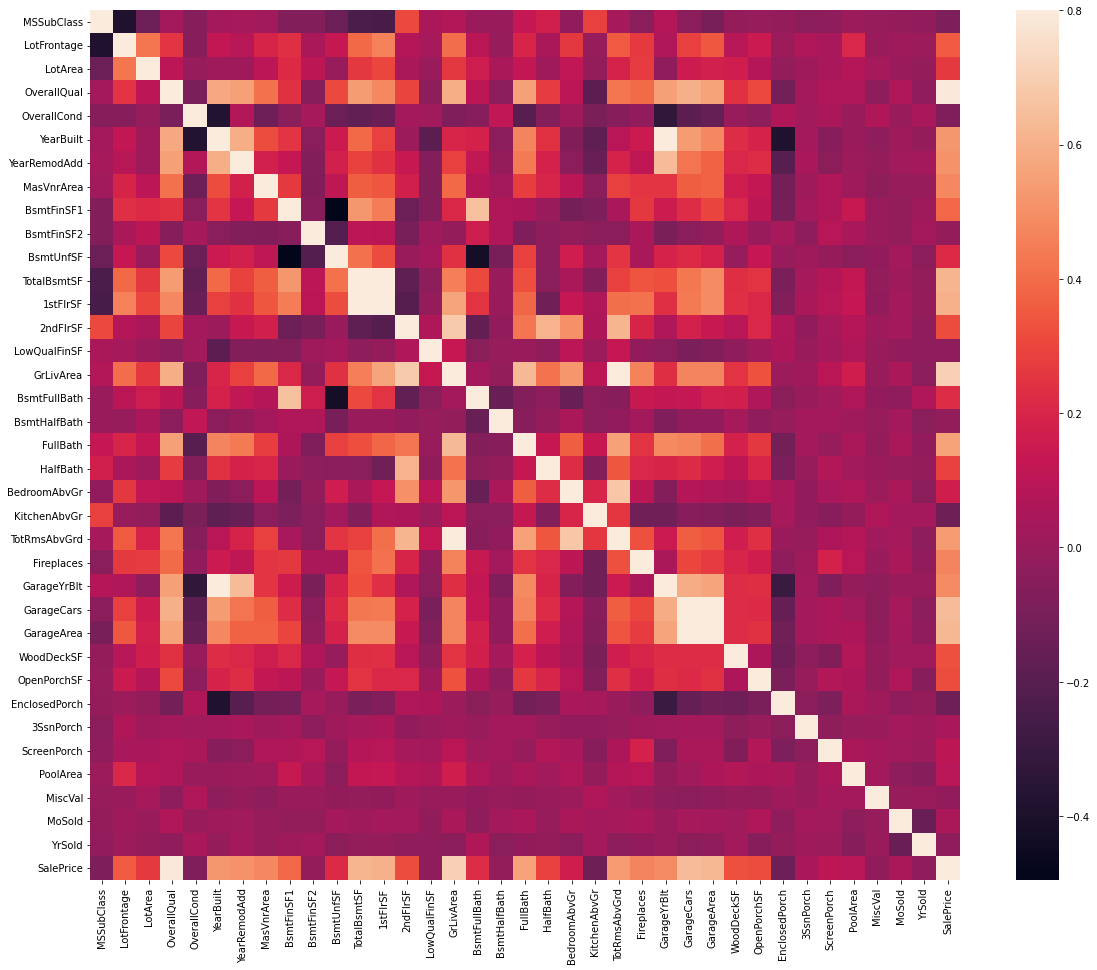

In [7]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(20, 16))
sns.heatmap(corrmat, vmax=.8, square=True);

/home/test/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

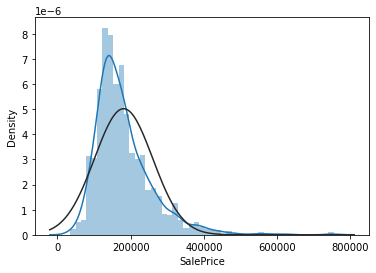

In [17]:
sns.distplot(train['SalePrice'] , fit=norm)

Есть несколько фич с хорошей линейной корреляцией, есть большой шанс на успех) 
так же можно заметить что есть столбцы с маленьким количеством ненулевых значений, c ними нужно поработать
Цены имеют большие выбросы, нужно прологорифмировать

In [8]:
total = df.isnull().sum().sort_values(ascending=False)
total.head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageCond        81
GarageFinish      81
GarageQual        81
GarageYrBlt       81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
RoofMatl           0
dtype: int64

In [9]:
# видно что большенство нонов связанно с отсутвием предмета в доме, поэтому заменем на стринг None
for i in ('Alley', 'MiscFeature', 'PoolQC', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    df[i] = df[i].fillna('None')

# также пустые численные значения заменем 0
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    df[col] = df[col].fillna(0)

In [20]:
#прологарифмируем чтобы сделать распеределение более нормальным
y = np.log(df.SalePrice).to_numpy()

#оставшиеся пустые значения заменим средним
train = df.fillna(df.mean())
X = train.drop(['SalePrice'], axis=1)

X = pd.get_dummies(X)

In [21]:
X

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,0,0,0,1,0,0,0,0,1,0
1456,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,0,0,0,1,0,0,0,0,1,0
1457,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,0,0,0,1,0,0,0,0,1,0
1458,20,68.0,9717,5,6,1950,1996,0.0,49,1029,...,0,0,0,1,0,0,0,0,1,0


In [25]:
# используем RFE и выберем полезные фичи
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
selector = RFECV(Ridge(), step=1, cv=5)
selector = selector.fit(scaler1.fit_transform(X), y)
selector.support_
X = X[X.columns[selector.support_]]
X

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,TotalBsmtSF,1stFlrSF,...,Functional_Maj2,Functional_Typ,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_None,SaleType_COD,SaleType_ConLI,SaleType_WD,SaleCondition_Normal
0,60,65.0,8450,7,5,2003,2003,706,856,856,...,0,1,0,0,0,1,0,0,1,1
1,20,80.0,9600,6,8,1976,1976,978,1262,1262,...,0,1,0,0,0,1,0,0,1,1
2,60,68.0,11250,7,5,2001,2002,486,920,920,...,0,1,0,0,0,1,0,0,1,1
3,70,60.0,9550,7,5,1915,1970,216,756,961,...,0,1,0,0,0,1,0,0,1,0
4,60,84.0,14260,8,5,2000,2000,655,1145,1145,...,0,1,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0,953,953,...,0,1,0,0,0,1,0,0,1,1
1456,20,85.0,13175,6,6,1978,1988,790,1542,2073,...,0,0,0,0,0,1,0,0,1,1
1457,70,66.0,9042,7,9,1941,2006,275,1152,1188,...,0,1,0,0,0,1,0,0,1,1
1458,20,68.0,9717,5,6,1950,1996,49,1078,1078,...,0,1,0,0,0,1,0,0,1,1


In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
scaler = StandardScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
model = GradientDescent(max_iterations=1000, alpha=0.1)
model(X_train, y_train)
model.evaluete(X_test,y_test)

{'mse': 0.07053874639668084,
 'rmse': 0.26559131461077723,
 'r2_score': 0.6220062348163968}

In [27]:
sk_model = Ridge()
sk_model.fit(X_train, y_train)
evaluete(X_test, y_test, sk_model)

{'mse': 0.012874709663915023,
 'rmse': 0.11346677779823935,
 'r2_score': 0.931008697629223}

ridge из sklearn работает лучше

In [36]:
from sklearn.model_selection import KFold, cross_validate

scoring = {'mse': 'neg_mean_squared_error',
           'rmse': 'neg_root_mean_squared_error',
           'r2': 'r2'}

k_folds = KFold(n_splits = 5, random_state=42, shuffle=True)
table = cross_validate(Ridge(), X, y, cv = k_folds,
                                scoring=scoring,
                                return_train_score = True)


In [37]:
del table['fit_time']
del table['score_time']

In [30]:
df_table = pd.DataFrame()
df_table['mse-test'] = table['test_mse']*-1
df_table['mse-train'] = table['train_mse']*-1
df_table['rmse-test'] = table['test_rmse']*-1
df_table['rmse-train'] = table['train_rmse']*-1
df_table['r2-train'] = table['train_r2']
df_table['r2-test'] = table['test_r2']

In [31]:
df_table = df_table.T

In [33]:
df_table['E'] = df_table.mean(axis=1)
df_table['STD'] = df_table.std(axis=1)

In [34]:
df_table

,0,1,2,3,4,E,STD
mse-test,0.015102,0.012881,0.052327,0.014363,0.012982,0.021531,0.015421
mse-train,0.012487,0.012811,0.010088,0.012330,0.013003,0.012144,0.001055
rmse-test,0.122889,0.113495,0.228752,0.119846,0.113939,0.139784,0.044626
rmse-train,0.111744,0.113188,0.100440,0.111040,0.114029,0.110088,0.004937
r2-train,0.918091,0.920032,0.938521,0.920464,0.921378,0.923697,0.007489
r2-test,0.919075,0.917114,0.628520,0.918794,0.904302,0.857561,0.114651


После крос валидации видно что значения разняться не сильно, откланение не большое, значит наша модель не переобучается

# Дополнительные задания

In [430]:
import random
class SGD(GradientDescent):
    def __call__(self, X, y):
        # initial weigts      
        self.w = np.random.randn(np.shape(X)[1])
        self.b = 0
        for i in range(self.max_iterations):
            indexes = random.choices(range(0, np.shape(X)[0]), k=1)
            gradient, b = self.step(X[indexes], y[indexes])
            self.update_weigts(gradient, b)
        return self.w 

    
class MiniBatch(GradientDescent):
    def __call__(self, X, y):
        # initial weigts      
        self.w = np.random.randn(np.shape(X)[1])
        self.b = 0
        for i in range(self.max_iterations):
            indexes = random.choices(range(0, np.shape(X)[0]), k=500)
            gradient, b = self.step(X[indexes], y[indexes])
            self.update_weigts(gradient, b)
        return self.w 

In [ ]:
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
param_grid = {'lambd':[0.5, 1, 1.5, 2, 2.5, 4], 'alpha':[0.2, 0.1, 0.01, 0.05, 0.5], 'max_iterations':[1000, 100]}
models = [SGD(), MiniBatch(), GradientDescent()]
params = []
for model in models:
    sh = HalvingGridSearchCV(model, param_grid, cv=5,
                             factor=2, min_resources=20).fit(X_train, y_train)
    params.append(sh.best_estimator_)

In [400]:
params

[SGD(alpha=0.2, lambd=1.5),
 MiniBatch(alpha=0.2, lambd=2.5),
 GradientDescent(alpha=0.2, lambd=2.5)]

In [431]:
models = [SGD(alpha=0.1, lambd=2, max_iterations=1000), MiniBatch(alpha=0.1, lambd=2.5, max_iterations=1000), GradientDescent(alpha=0.1, lambd=2.5), Ridge()]
res = dict()
for model, name in zip(models, ['sgd', 'minibatch', 'gd', 'ridge']): 
    model.fit(X_train, y_train)
    for i,k in evaluete(X_train, y_train, model).items():
        res[f'train_{name}_{i}'] = k
    
    for i,k in evaluete(X_test, y_test, model).items():
        res[f'test_{name}_{i}'] = k 
    

In [432]:
res

{'train_sgd_mse': 1.0816835058431643e+258,
 'train_sgd_rmse': 1.0400401462651161e+129,
 'train_sgd_r2_score': -7.095594123772516e+258,
 'test_sgd_mse': 5.797622371900826e+257,
 'test_sgd_rmse': 7.61421195653288e+128,
 'test_sgd_r2_score': -3.106753694123778e+258,
 'train_minibatch_mse': 0.013446320656369571,
 'train_minibatch_rmse': 0.1159582711856708,
 'train_minibatch_r2_score': 0.9117952401785716,
 'test_minibatch_mse': 0.01924849154553986,
 'test_minibatch_rmse': 0.13873893305608148,
 'test_minibatch_r2_score': 0.8968537128163973,
 'train_gd_mse': 0.012925676372563767,
 'train_gd_rmse': 0.11369114465323923,
 'train_gd_r2_score': 0.9152105465050451,
 'test_gd_mse': 0.01892091249965111,
 'test_gd_rmse': 0.1375533078469984,
 'test_gd_r2_score': 0.8986091003626178,
 'train_ridge_mse': 0.012904167819440529,
 'train_ridge_rmse': 0.11359651323628084,
 'train_ridge_r2_score': 0.9153516376489219,
 'test_ridge_mse': 0.019315989951379724,
 'test_ridge_rmse': 0.13898197707393475,
 'test_ridge_

видно что у sgd метрики несколько ниже, вероятно это произошло из-за маленького количества итерация, в связи счем модель не смогла оптемизироваться под все данные